In [51]:
#from __future__ import division
#from __future__ import print_function

import time
import argparse
import pickle
import os
import datetime

import torch.optim as optim
from torch.optim import lr_scheduler

from utils import *
from modules import *
import matplotlib as plt


# prepare params

In [52]:
torch.cuda.is_available()

False

In [165]:
##### set params

parser = argparse.ArgumentParser('-cuda')


parser.add_argument('--no-cuda', action='store_true', default=True,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=500,
                    help='Number of epochs to train.')
parser.add_argument('--batch-size', type=int, default=128,
                    help='Number of samples per batch.')
parser.add_argument('--lr', type=float, default=0.0005,
                    help='Initial learning rate.')
parser.add_argument('--encoder-hidden', type=int, default=256,
                    help='Number of hidden units.')
parser.add_argument('--decoder-hidden', type=int, default=256,
                    help='Number of hidden units.')
parser.add_argument('--temp', type=float, default=0.5,
                    help='Temperature for Gumbel softmax.')
parser.add_argument('--num-atoms', type=int, default=5,
                    help='Number of atoms in simulation.')
parser.add_argument('--encoder', type=str, default='mlp',
                    help='Type of path encoder model (mlp or cnn).')
parser.add_argument('--decoder', type=str, default='rnn',
                    help='Type of decoder model (mlp, rnn, or sim).')
parser.add_argument('--no-factor', action='store_true', default=False,
                    help='Disables factor graph model.')
parser.add_argument('--suffix', type=str, default='_springs5',
                    help='Suffix for training data (e.g. "_charged".')
parser.add_argument('--encoder-dropout', type=float, default=0.0,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--decoder-dropout', type=float, default=0.0,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--save-folder', type=str, default='logs',
                    help='Where to save the trained model, leave empty to not save anything.')
parser.add_argument('--load-folder', type=str, default='',
                    help='Where to load the trained model if finetunning. ' +
                         'Leave empty to train from scratch')
parser.add_argument('--edge-types', type=int, default=2,
                    help='The number of edge types to infer.')
parser.add_argument('--dims', type=int, default=4,
                    help='The number of input dimensions (position + velocity).')
parser.add_argument('--timesteps', type=int, default=49,
                    help='The number of time steps per sample.')
parser.add_argument('--prediction-steps', type=int, default=10, metavar='N',
                    help='Num steps to predict before re-using teacher forcing.')
parser.add_argument('--lr-decay', type=int, default=200,
                    help='After how epochs to decay LR by a factor of gamma.')
parser.add_argument('--gamma', type=float, default=0.5,
                    help='LR decay factor.')
parser.add_argument('--skip-first', action='store_true', default=False,
                    help='Skip first edge type in decoder, i.e. it represents no-edge.')
parser.add_argument('--var', type=float, default=5e-5,
                    help='Output variance.')
parser.add_argument('--hard', action='store_true', default=False,
                    help='Uses discrete samples in training forward pass.')
parser.add_argument('--prior', action='store_true', default=False,
                    help='Whether to use sparsity prior.')
parser.add_argument('--dynamic-graph', action='store_true', default=False,
                    help='Whether test with dynamically re-computed graph.')

args, unknown = parser.parse_known_args('--epochs 5'.split())

args.cuda = not args.no_cuda and torch.cuda.is_available()
args.factor = not args.no_factor
print(args)


################## set params end ################

Namespace(batch_size=128, cuda=False, decoder='rnn', decoder_dropout=0.0, decoder_hidden=256, dims=4, dynamic_graph=False, edge_types=2, encoder='mlp', encoder_dropout=0.0, encoder_hidden=256, epochs=5, factor=True, gamma=0.5, hard=False, load_folder='', lr=0.0005, lr_decay=200, no_cuda=True, no_factor=False, num_atoms=5, prediction_steps=10, prior=False, save_folder='logs', seed=42, skip_first=False, suffix='_springs5', temp=0.5, timesteps=49, var=5e-05)


# save log

In [166]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

if args.dynamic_graph:
    print("Testing with dynamically re-computed graph.")

# Save model and meta-data. Always saves in a new sub-folder.
if args.save_folder:
    exp_counter = 0
    now = datetime.datetime.now()
    timestamp = now.isoformat()
    save_folder = '{}/exp{}/'.format(args.save_folder, timestamp)
    try:
        os.makedirs(save_folder)
    except:
        pass
    meta_file = os.path.join(save_folder, 'metadata.pkl')
    encoder_file = os.path.join(save_folder, 'encoder.pt')
    decoder_file = os.path.join(save_folder, 'decoder.pt')

    log_file = os.path.join(save_folder, 'log.txt')
    log = open(log_file, 'w')

    pickle.dump({'args': args}, open(meta_file, "wb"))
else:
    print("WARNING: No save_folder provided!" +
          "Testing (within this script) will throw an error.")

# prepare data


+ Load data from a pytorch dataloader instance (create in util)
    + contains simulation data

+ processing graph data 
    + a 5*5 adjacent matrix -> sender and receiver
        + sender: one-hot form of row index of non-zero off-diagoal element  
        + receiver one-hot form of column index of non-zero off-diagoal element
     

In [167]:
# pytorch dataloader 
train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(
    args.batch_size, args.suffix)


In [168]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

# Generate off-diagonal interaction graph

off_diag = np.ones([args.num_atoms, args.num_atoms]) - np.eye(args.num_atoms)

rel_rec = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec)
rel_send = torch.FloatTensor(rel_send)


In [169]:
# Generate off-diagonal interaction graph

off_diag = np.ones([args.num_atoms, args.num_atoms]) - np.eye(args.num_atoms)

rel_rec = np.array(encode_onehot(np.where(off_diag)[0]), dtype=np.float32)
rel_send = np.array(encode_onehot(np.where(off_diag)[1]), dtype=np.float32)
rel_rec = torch.FloatTensor(rel_rec)
rel_send = torch.FloatTensor(rel_send)


In [170]:
print('idx(row idx and column idx) of non-zero element from off-diags \n',np.where(off_diag)) #  idx of non-zero element of off-diag matrix

idx(row idx and column idx) of non-zero element from off-diags 
 (array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4]), array([1, 2, 3, 4, 0, 2, 3, 4, 0, 1, 3, 4, 0, 1, 2, 4, 0, 1, 2, 3]))


data explore

In [171]:
print('off_diag = \n', off_diag)
print(rel_rec.shape)
print(rel_rec) # change row idx (recevier) to one-hot encoding

off_diag = 
 [[0. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1.]
 [1. 1. 0. 1. 1.]
 [1. 1. 1. 0. 1.]
 [1. 1. 1. 1. 0.]]
torch.Size([20, 5])
tensor([[1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.]])


# define encoder

In [172]:
encoder = MLPEncoder(args.timesteps * args.dims, args.encoder_hidden,
                         args.edge_types,
                         args.encoder_dropout, args.factor)





Using factor graph MLP encoder.


# Define Decoder

task: predict $$p_{\theta}\left(\mathbf{x}^{t+1} \mid \mathbf{x}^{t}, \cdots, \mathbf{x}^{1}, \mathbf{z}\right)$$ 

(under markov $$p_{\theta}\left(\mathbf{x}^{t+1} \mid \mathbf{x}^{t}, \cdots, \mathbf{x}^{1}, \mathbf{z}\right)=p_{\theta}\left(\mathbf{x}^{t+1} \mid \mathbf{x}^{t}, \mathbf{z}\right)$$)




`rnn`

\begin{aligned}
v \rightarrow e: \tilde{\mathbf{h}}_{(i, j)}^{t} &=\sum_{k} z_{i j, k} \tilde{f}_{e}^{k}\left(\left[\tilde{\mathbf{h}}_{i}^{t}, \tilde{\mathbf{h}}_{j}^{t}\right]\right) \\
e \rightarrow v: \operatorname{MSG}_{j}^{t} &=\sum_{i \neq j} \tilde{\mathbf{h}}_{(i, j)}^{t} \\
\tilde{\mathbf{h}}_{j}^{t+1} &=\operatorname{GRU}\left(\left[\operatorname{MSG}_{j}^{t}, \mathbf{x}_{j}^{t}\right], \tilde{\mathbf{h}}_{j}^{t}\right) \\
\boldsymbol{\mu}_{j}^{t+1} &=\mathbf{x}_{j}^{t}+f_{\text {out }}\left(\tilde{\mathbf{h}}_{j}^{t+1}\right) \\
p\left(\mathbf{x}^{t+1} \mid \mathbf{x}^{t}, \mathbf{z}\right) &=\mathcal{N}\left(\boldsymbol{\mu}^{t+1}, \sigma^{2} \mathbf{I}\right)
\end{aligned}


In [173]:
class RNNDecoder(nn.Module):
    def __init__(self, n_in_node, edge_types, n_hid, do_prob = 0., skip_first=False):
        '''
        About params
            + n_in_node: number of balls = 5 in default
            + edge_types: arbitrary num, = 2 in default (connected or unconnected)
            + n_hid: a hyper params, set the num of units of inner layer of decoder, = 256 in default


        '''
        super(RNNDecoder, self).__init__()
        
        # pre define some nn blocks
        self.msg_fc1 = nn.ModuleList(
            [nn.Linear(2 * n_hid, n_hid) for _ in range(edge_types)])
        self.msg_fc2 = nn.ModuleList(
            [nn.Linear(n_hid, n_hid) for _ in range(edge_types)])
        self.msg_out_shape = n_hid
        self.skip_first_edge_type = skip_first

        self.hidden_r = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_i = nn.Linear(n_hid, n_hid, bias=False)
        self.hidden_h = nn.Linear(n_hid, n_hid, bias=False)

        self.input_r = nn.Linear(n_in_node, n_hid, bias=True)
        self.input_i = nn.Linear(n_in_node, n_hid, bias=True)
        self.input_n = nn.Linear(n_in_node, n_hid, bias=True)

        self.out_fc1 = nn.Linear(n_hid, n_hid)
        self.out_fc2 = nn.Linear(n_hid, n_hid)
        self.out_fc3 = nn.Linear(n_hid, n_in_node)
    
        print('Using learned recurrent interaction net decoder.')

        self.dropout_prob = do_prob
        
    def single_step_forward(self, inputs, rel_rec, rel_send, rel_type, hidden):
        '''
        Single: means a single timestep 
        
        arguments:
            + inputs:(a timestep)             + inputs: 
                                            + 'data', vel and loc [batch_size, num_atoms, num_timesteps, num_dims * num_variables]
                                                    + in example: train data shape torch.Size([128, 49, 5, 4])
                                                        + batch_size = 128
                                                        + ball num
                                                        + timesteps records
                                                        + 2-dim vel + 2-dim loc
                    + ins = inputs[:, step, :, :]
                        + [128, 5, 4]
                        
            + rel_rec:
                + [num of non-zero-off-diagonal element(in this case, 5*5 - 5),  n_balls(encoding dim)]
                    + in example :rel_rec shape torch.Size([20, 5])
            
            + rel_send:
                + same as rel_rec
            
            + rel_type: (for extracting info from a specific type edge)
                + [batchsize, num of non-zero-off-diagonal element, n_type] 
                    + in eg: rel_type shape torch.Size([128, 20, 2])
            
            + hidden: 256(hyperparams)
                
                    

        '''

        
        ############## node2edge
        
        ######## (13)
        #print('inputs', inputs.shape)
        receivers = torch.matmul(rel_rec, hidden) #  fe pass hidden (20, 5) (128, 5, 256) -> 128 20 256              
        senders = torch.matmul(rel_send, hidden) #  fe
        pre_msg = torch.cat([senders, receivers], dim=-1)   # contatenate # (13 [h, h])
        #print('pre_msg size', pre_msg.shape) # pre_msg size torch.Size([128, 20, 512])
        
        # init zeros... for later fill out
        all_msgs = Variable(torch.zeros(pre_msg.size(0), pre_msg.size(1),
                                        self.msg_out_shape)) # (128, 20, 256) # msg_out_shape=256=n_hid
                     
        ############# ignore
        if inputs.is_cuda:
            all_msgs = all_msgs.cuda()

            
            
        if self.skip_first_edge_type:
            start_idx = 1
            norm = float(len(self.msg_fc2)) - 1.
        else:
            start_idx = 0
            norm = float(len(self.msg_fc2))

            
        
        ############### edge2node 
        ####### (14)
        # Run separate MLP for every edge type (in this case, 2)
        # Only take graph edge-type, structure info
        for i in range(start_idx, len(self.msg_fc2)):            
            msg = F.tanh(self.msg_fc1[i](pre_msg)) # 512 -> 256
            msg = F.dropout(msg, p=self.dropout_prob)
            msg = F.tanh(self.msg_fc2[i](msg)) # 256 ->256
            msg = msg * rel_type[:, :, i:i + 1]   # only extract edge type i 
            all_msgs += msg / norm   
        # (128, 256, 20) (20, 5) = (128, 256, 5)....5 balls receive msg from others (4 each, 20 total)
        agg_msgs = all_msgs.transpose(-2, -1).matmul(rel_rec).transpose(-2, -1)# all msgs 
        agg_msgs = agg_msgs.contiguous() / inputs.size(2)  # agg_msgs torch.Size([128, 5, 256])
        #print('agg_msgs', agg_msgs.shape)
        
        ####### (15)
        # GRU-style gated aggregation
        # single input (128, 5 , 4) -> (128, 5, 256), sum... GRU style
        r = F.sigmoid(self.input_r(inputs) + self.hidden_r(agg_msgs))  
        i = F.sigmoid(self.input_i(inputs) + self.hidden_i(agg_msgs))     
        n = F.tanh(self.input_n(inputs) + r * self.hidden_h(agg_msgs))
        hidden = (1 - i) * n + i * hidden   
        
        ####### (16 right) 
        # Output MLP f_out
        pred = F.dropout(F.relu(self.out_fc1(hidden)), p=self.dropout_prob)
        pred = F.dropout(F.relu(self.out_fc2(pred)), p=self.dropout_prob)
        pred = self.out_fc3(pred)

        ####### (16)
        # Predict position/velocity difference
        pred = inputs + pred 

        return pred, hidden

    def forward(self, data, rel_type, rel_rec, rel_send, pred_steps=1,
                burn_in=False, burn_in_steps=1, dynamic_graph=False,
                encoder=None, temp=None):
        '''
        data torch.Size([128, 5, 49, 4])
        rel_type torch.Size([128, 20, 2])
        rel_rec torch.Size([20, 5])
        rel_send torch.Size([20, 5])
        
        '''
        #print('data', data.shape)  
        #print('rel_type', rel_type.shape)
        #print('rel_rec', rel_rec.shape)
        #print('rel_send', rel_send.shape)
        
        
        ##### ignore
        inputs = data.transpose(1, 2).contiguous() #  ([128, 5, 49, 4]) -> ([128, 49, 5, 4])
        time_steps = inputs.size(1)
        
        hidden = Variable(
            torch.zeros(inputs.size(0), inputs.size(2), self.msg_out_shape)) 
        
        if inputs.is_cuda:
            hidden = hidden.cuda()

        pred_all = []
        
        
        ####### timesteps loop
        for step in range(0, inputs.size(1) - 1):
            
            # if < , use self.info
            if burn_in:
                if step <= burn_in_steps:
                    ins = inputs[:, step, :, :]
                else:
                    ins = pred_all[step - 1] 
            else:
                assert (pred_steps <= time_steps)
                # Use ground truth trajectory input vs. last prediction
                if not step % pred_steps:
                    ins = inputs[:, step, :, :]
                else:
                    ins = pred_all[step - 1]

            if dynamic_graph and step >= burn_in_steps:
                # NOTE: Assumes burn_in_steps = args.timesteps
                logits = encoder(
                    data[:, :, step - burn_in_steps:step, :].contiguous(),
                    rel_rec, rel_send)
                # logits shape =  torch.Size([128, 20, 2])
                rel_type = gumbel_softmax(logits, tau=temp, hard=True)
                # sampled.. rel_type ([128, 20, 2])
            pred, hidden = self.single_step_forward(ins, rel_rec, rel_send,
                                                    rel_type, hidden)
            pred_all.append(pred)

        preds = torch.stack(pred_all, dim=1)

        return preds.transpose(1, 2).contiguous()        
        
        #print("rel_type shape", rel_type.shape)
        # node2edge
        receivers = torch.matmul(rel_rec, hidden) # receivers shape =  torch.Size([128, 20, 256])
                                                # (128, 20 ,5 ) * ([128, 5, 256])
        senders = torch.matmul(rel_send, hidden)
                                                
        pre_msg = torch.cat([])

In [174]:
# use rnn
decoder = RNNDecoder(n_in_node=args.dims,
                     edge_types=args.edge_types,
                     n_hid=args.decoder_hidden,
                     do_prob=args.decoder_dropout,
                     skip_first=args.skip_first)

Using learned recurrent interaction net decoder.


In [175]:
if args.load_folder:
    encoder_file = os.path.join(args.load_folder, 'encoder.pt')
    encoder.load_state_dict(torch.load(encoder_file))
    decoder_file = os.path.join(args.load_folder, 'decoder.pt')
    decoder.load_state_dict(torch.load(decoder_file))

    args.save_folder = False


In [176]:
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),
                       lr=args.lr)

scheduler = lr_scheduler.StepLR(optimizer, step_size=args.lr_decay,
                                gamma=args.gamma)

In [177]:
# Linear indices of an upper triangular mx, used for acc calculation
triu_indices = get_triu_offdiag_indices(args.num_atoms)
tril_indices = get_tril_offdiag_indices(args.num_atoms)


In [178]:
if args.prior:
    ### default 不用这个 (用 1/2， 1/2)
    prior = np.array([0.91, 0.03, 0.03, 0.03])  # TODO: hard coded for now
    print("Using prior")
    print(prior)
    log_prior = torch.FloatTensor(np.log(prior))
    log_prior = torch.unsqueeze(log_prior, 0)
    log_prior = torch.unsqueeze(log_prior, 0)
    log_prior = Variable(log_prior)

    if args.cuda:
        log_prior = log_prior.cuda()

if args.cuda:
    encoder.cuda()
    decoder.cuda()
    rel_rec = rel_rec.cuda()
    rel_send = rel_send.cuda()
    triu_indices = triu_indices.cuda()
    tril_indices = tril_indices.cuda()

rel_rec = Variable(rel_rec)
rel_send = Variable(rel_send)


# define train

In [182]:

def train(epoch, best_val_loss):
    t = time.time()
    nll_train = []
    acc_train = []
    kl_train = []
    mse_train = []
    graph_rc_train = []

    encoder.train()
    decoder.train()
    scheduler.step()
    for batch_idx, (data, relations) in enumerate(train_loader):

        #print('relations',relations.shape). torch Size (128, 20)
        #print('relations', relations[0,:])
        if args.cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data), Variable(relations)
        #print("train data shape", data.shape) # 
        optimizer.zero_grad()
        
        ######## encoder
        logits = encoder(data, rel_rec, rel_send)
        #print("logits shape = ", logits.size())
        edges = gumbel_softmax(logits, tau=args.temp, hard=args.hard)
        train_edges = edges
        # print('edge shape', edges.shape) edge shape torch.Size([128, 20, 2])
        #print('edges', edges[0,:,:])
        prob = my_softmax(logits, -1)
        ######## decoder
        output = decoder(data, edges, rel_rec, rel_send, 100,
                             burn_in=True,
                             burn_in_steps=args.timesteps - args.prediction_steps)

        target = data[:, :, 1:, :]
        
        ####### cal loss
        loss_nll = nll_gaussian(output, target, args.var)

        if args.prior:
            loss_kl = kl_categorical(prob, log_prior, args.num_atoms)
        else:
            loss_kl = kl_categorical_uniform(prob, args.num_atoms,
                                             args.edge_types)

        loss = loss_nll + loss_kl
        
        
        ##### other metric
        acc = edge_accuracy(logits, relations)
        acc_train.append(acc)
        
        ##### backward
        loss.backward()
        optimizer.step()
#        print('F.mse_loss(output, target).data', F.mse_loss(output, target).data)
        mse_train.append(F.mse_loss(output, target).item())
        nll_train.append(loss_nll.item())
        kl_train.append(loss_kl.item())
        
        ############## graph reconstruct loss
            ######### graph reconstruct loss (not trajectory)
        np_prob = prob.detach().numpy()
        relations_reconstruct = (np_prob[:,:,0] < np_prob[:,:,1])*1
        relations_ori = relations.detach().numpy()
        
        def diff_np(array1, array2):
            array3 = np.where((array1-array2)!=0, 1, 0)
            loss = np.sum(array3) / (array3.shape[0]*array3.shape[1])
            return loss
        
        
        graph_loss = diff_np(relations_reconstruct, relations_ori)

        graph_rc_train.append(graph_loss)



    ################################### validation #################################



    nll_val = []
    acc_val = []
    kl_val = []
    mse_val = []
    graph_rc_val =[]

    encoder.eval()
    decoder.eval()
    for batch_idx, (data, relations) in enumerate(valid_loader):
        if args.cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)

        logits = encoder(data, rel_rec, rel_send)
        edges = gumbel_softmax(logits, tau=args.temp, hard=True)
        prob = my_softmax(logits, -1)

        # validation output uses teacher forcing
        output = decoder(data, edges, rel_rec, rel_send, 1)

        target = data[:, :, 1:, :]
        loss_nll = nll_gaussian(output, target, args.var)
        loss_kl = kl_categorical_uniform(prob, args.num_atoms, args.edge_types)

        acc = edge_accuracy(logits, relations)
        acc_val.append(acc)

        mse_val.append(F.mse_loss(output, target).item())
        nll_val.append(loss_nll.item())
        kl_val.append(loss_kl.item())

        ############## graph reconstruct loss
            ######### graph reconstruct loss (not trajectory)
        np_prob = prob.detach().numpy()
        relations_reconstruct = (np_prob[:,:,0] < np_prob[:,:,1])*1
        relations_ori = relations.detach().numpy()
        
        def diff_np(array1, array2):
            array3 = np.where((array1-array2)!=0, 1, 0)
            loss = np.sum(array3) / (array3.shape[0]*array3.shape[1])
            return loss
        
        
        graph_loss_val = diff_np(relations_reconstruct, relations_ori)

        graph_rc_val.append(graph_loss_val)

    ####################### print process ########################

    #nll_vall, np.mean(nll_val), np.mean(loss_nll), np.mean(kl_val), 
    print('Epoch: {:04d}'.format(epoch),
          'nll_train: {:.10f}'.format(np.mean(nll_train)),'\n',
          'kl_train: {:.10f}'.format(np.mean(kl_train)),'\n',
          'mse_train: {:.10f}'.format(np.mean(mse_train)),'\n',
          'acc_train: {:.10f}'.format(np.mean(acc_train)),'\n',
          'nll_val: {:.10f}'.format(np.mean(nll_val)),'\n',
          'kl_val: {:.10f}'.format(np.mean(kl_val)),'\n',
          'mse_val: {:.10f}'.format(np.mean(mse_val)),'\n',
          'acc_val: {:.10f}'.format(np.mean(acc_val)),'\n',
          'graph reconstruction val: {:.10f}'.format(graph_loss_val),'\n',
          'time: {:.4f}s'.format(time.time() - t))
    if args.save_folder and np.mean(nll_val) < best_val_loss:
        torch.save(encoder.state_dict(), encoder_file)
        torch.save(decoder.state_dict(), decoder_file)
        print('Best model so far, saving...')
        print('Epoch: {:04d}'.format(epoch),
              'nll_train: {:.10f}'.format(np.mean(nll_train)),
              'kl_train: {:.10f}'.format(np.mean(kl_train)),
              'mse_train: {:.10f}'.format(np.mean(mse_train)),
              'acc_train: {:.10f}'.format(np.mean(acc_train)),
              'nll_val: {:.10f}'.format(np.mean(nll_val)),
              'kl_val: {:.10f}'.format(np.mean(kl_val)),
              'mse_val: {:.10f}'.format(np.mean(mse_val)),
              'acc_val: {:.10f}'.format(np.mean(acc_val)),
              'time: {:.4f}s'.format(time.time() - t), file=log)
        log.flush()


    ####################### plot process ########################





    return np.mean(nll_val), nll_train, nll_val, kl_train, kl_val, graph_rc_train, graph_rc_val 


# train model

In [183]:
###### Train model
t_total = time.time()
best_val_loss = np.inf
best_epoch = 0



for epoch in range(args.epochs):
    val_loss, nll_train, nll_val, kl_train, kl_val, graph_rc_train, graph_rc_val  = train(epoch, best_val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
    #break # test
    
    
    
    
print("Optimization Finished!")
print("Best Epoch: {:04d}".format(best_epoch))
if args.save_folder:
    print("Best Epoch: {:04d}".format(best_epoch), file=log)
    log.flush()


Epoch: 0000 nll_train: 910.2550048828 
 kl_train: -0.3010472059 
 mse_train: 0.0004740911 
 acc_train: 0.4961712015 
 nll_val: 174.2114562988 
 kl_val: -0.3160119057 
 mse_val: 0.0000907351 
 acc_val: 0.5230000000 
 graph reconstruction val: 0.4770000000 
 time: 16.5878s
Best model so far, saving...
Epoch: 0001 nll_train: 784.0380249023 
 kl_train: -0.3137766197 
 mse_train: 0.0004083532 
 acc_train: 0.5048323006 
 nll_val: 103.5264663696 
 kl_val: -0.3660626113 
 mse_val: 0.0000539200 
 acc_val: 0.5270000000 
 graph reconstruction val: 0.4730000000 
 time: 16.7511s
Best model so far, saving...
Epoch: 0002 nll_train: 654.8073120117 
 kl_train: -0.3246520460 
 mse_train: 0.0003410455 
 acc_train: 0.5012830011 
 nll_val: 109.3751754761 
 kl_val: -0.3685659170 
 mse_val: 0.0000569662 
 acc_val: 0.5155000000 
 graph reconstruction val: 0.4845000000 
 time: 16.9513s
Epoch: 0003 nll_train: 596.9442596436 
 kl_train: -0.3095794246 
 mse_train: 0.0003109085 
 acc_train: 0.4941574623 
 nll_val:

In [184]:
def plot_metrics(loss_lst1, loss_lst2, title, ylimup=5, ylimdown=0):
    '''
    loss_lst1: train
    loss_lst2: val
    title: string
    '''
    plt.title(title)
    plt.ylim(ylimdown,ylimup)
    plt.plot(loss_lst1,color='blue',label=title)
    plt.plot(loss_lst1,color='green',label='val_' + title)


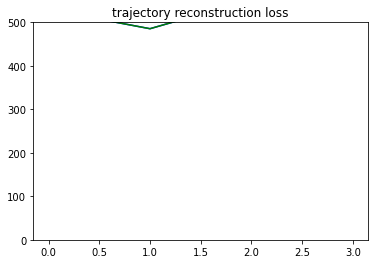

In [188]:
plot_metrics(nll_train, nll_val, 'trajectory reconstruction loss', ylimup=500)


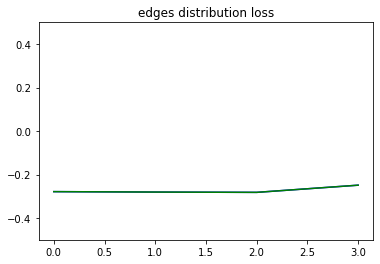

In [190]:
plot_metrics(kl_train, kl_val, 'edges distribution loss', ylimup=0.5, ylimdown=-0.5)


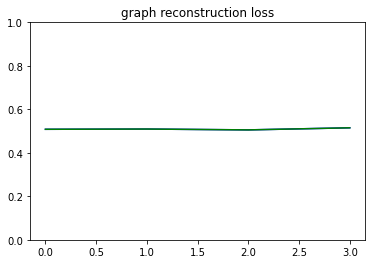

In [193]:
plot_metrics(graph_rc_train, graph_rc_val, 'graph reconstruction loss', ylimup=1, ylimdown=0)


# Test Model

In [128]:
# testing

acc_test = []
nll_test = []
kl_test = []
mse_test = []
tot_mse = 0
counter = 0

# turn off drop_out
encoder.eval()
decoder.eval()
# load trained model
encoder.load_state_dict(torch.load(encoder_file))
decoder.load_state_dict(torch.load(decoder_file))


# test batch
for batch_idxm, (data, relations) in enumerate(test_loader):
    if args.cuda:
        data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(relations, volatile=True)
        print('relations', relations.shape) # ([128, 20])

    assert (data.size(2) - args.timesteps) >= args.timesteps # still remain at least n_timesteps steps 
    # torch.Size([128, 5, 49, 4]) , arg.timesteps = 49


    data_encoder = data[:, :, :args.timesteps, :].contiguous() # 0~ 49
    data_decoder = data[:, :, -args.timesteps:, :].contiguous() # 50 ~ .

    # pred logits, output of fc_out(x) of encoder
    logits = encoder(data_encoder, rel_rec, rel_send)
    #print('logits', logits.shape) (100, 20, 2)
    
    edges = gumbel_softmax(logits, tau=args.temp, hard=True)
    #ize([128, 20, 2])
    # print(edges.shape)
    prob = my_softmax(logits, -1)  # 

    #print('prb_shape', prob[0,:])

    output = decoder(data_decoder, edges, rel_rec, rel_send, 1)

    target = data_decoder[:, :, 1:, :] # predict i+1 ~ n timesteps

    #print(target)

    # cal loss
    loss_nll = nll_gaussian(output, target, args.var)
    loss_kl = kl_categorical_uniform(prob, args.num_atoms, args.edge_types)

    acc = edge_accuracy(logits, relations)
    acc_test.append(acc)

    mse_test.append(F.mse_loss(output, target).item())
    nll_test.append(loss_nll.item())
    kl_test.append(loss_kl.item())

    # For plotting purposes
    
    if args.dynamic_graph:
        output = decoder(data, edges, rel_rec, rel_send, 100,
                            burn_in=True, burn_in_steps=args.timesteps,
                            dynamic_graph=True, encoder=encoder,
                            temp=args.temp)
    else:
        output = decoder(data, edges, rel_rec, rel_send, 100,
                            burn_in=True, burn_in_steps=args.timesteps)
    # fc_out(x), n_out = (128, 20 ,5 )
    output = output[:, :, args.timesteps:, :]
    target = data[:, :, -args.timesteps:, :]


    mse = ((target - output) ** 2).mean(dim=0).mean(dim=0).mean(dim=-1)
    tot_mse += mse.data.cpu().numpy()
    counter += 1

    mean_mse = tot_mse / counter
    mse_str = '['
    for mse_step in mean_mse[:-1]:
        mse_str += " {:.12f} ,".format(mse_step)
    mse_str += " {:.12f} ".format(mean_mse[-1])
    mse_str += ']'

    ######### graph reconstruct loss (not trajectory)
    np_prob = prob.detach().numpy()
    relations_reconstruct = (np_prob[:,:,0] < np_prob[:,:,1])*1
    relations_ori = relations.detach().numpy()
    def diff_np(array1, array2):
        array3 = np.where((array1-array2)!=0, 1, 0)
        loss = np.sum(array3) / (array3.shape[0]*array3.shape[1])
        return loss
    
    
    graph_loss = diff_np(relations_reconstruct, relations_ori)



    print('--------------------------------')
    print('--------Testing-----------------')
    print('--------------------------------')
    print('nll_test: {:.10f}'.format(np.mean(nll_test)),'\n',
          'kl_test: {:.10f}'.format(np.mean(kl_test)),'\n',
          'mse_test: {:.10f}'.format(np.mean(mse_test)),'\n',
          'acc_test: {:.10f}'.format(np.mean(acc_test)), '\n',
          'graph reconstruct loss: {:.10f}'.format(graph_loss))
    #print('MSE: {}'.format(mse_str))
    
    if args.save_folder:
        print('--------------------------------', file=log)
        print('--------Testing-----------------', file=log)
        print('--------------------------------', file=log)
        print('nll_test: {:.10f}'.format(np.mean(nll_test)),
              'kl_test: {:.10f}'.format(np.mean(kl_test)),
              'mse_test: {:.10f}'.format(np.mean(mse_test)),
              'acc_test: {:.10f}'.format(np.mean(acc_test)),
              file=log)
        print('MSE: {}'.format(mse_str), file=log)
        log.flush()






--------------------------------
--------Testing-----------------
--------------------------------
nll_test: 328.8021240234 
 kl_test: -0.2251578271 
 mse_test: 0.0001712511 
 acc_test: 0.4905000000 
 graph reconstruct loss: 0.5095000000


# Visualize Graph reconstruction performance

In [136]:
import matplotlib.pyplot as plt
#import torchvision.transforms as transforms

In [131]:
num_atoms = 5

In [132]:
def add_diag(edges_train_single):
    '''
    edges_train_single: (20, ) nparray
    '''
    diag_idx = np.ravel_multi_index(np.where( np.eye(num_atoms)),[num_atoms, num_atoms])
    
    added = np.insert(edges_train_single, diag_idx - range(0, diag_idx.shape[0]), 0, axis=0).reshape(num_atoms,num_atoms)

    return added

In [135]:
edges_ori_reconst = np.apply_along_axis(add_diag, 1, relations_ori)
edges_pred_reconst = np.apply_along_axis(add_diag, 1, relations_reconstruct)

In [134]:
edges_ori_reconst

(100, 5, 5)

In [207]:
def plot_pair(mat1, mat2):
    plt.matshow(mat1, cmap='brg', vmin=0, vmax=1)
    plt.matshow(mat2, cmap='brg', vmin=0, vmax=1)
    plt.colorbar()
    plt.show()

In [208]:
import random

validate via human eyes

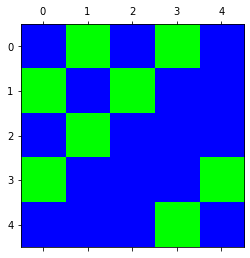

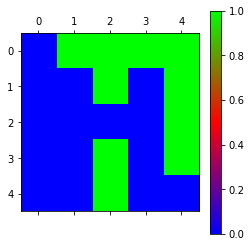

In [215]:
choice = random.randint(0, edges_ori_reconst.shape[0])
plot_pair(edges_ori_reconst[choice,:], edges_pred_reconst[choice,:])